Define

In [1]:
import sys
import torch.utils.data as tordata
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch
import torchvision
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
import SimpleITK as sitk
import glob

from datetime import datetime
from warnings import warn
from typing import Optional
# import torchvision.models as models
# %matplotlib inline
from collections import OrderedDict
import os
# from torchsummary import summary

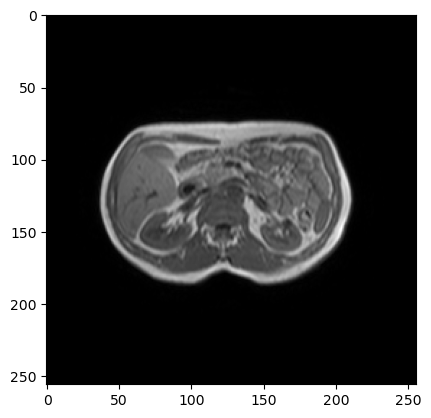

uint16


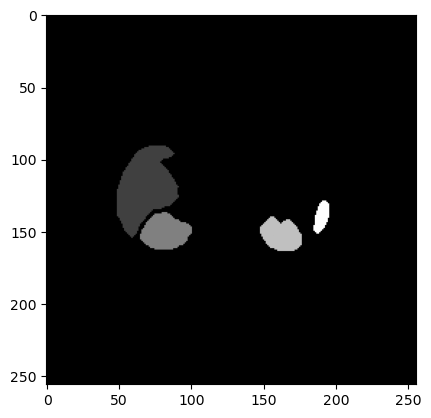

In [2]:
dicom_directory1 = '/bulk/liangy15/CHAOS/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/IMG-0004-00040.dcm'
dicom_directory2 = '/bulk/liangy15/CHAOS/Train_Sets/MR/1/T1DUAL/DICOM_anon/OutPhase/IMG-0004-00001.dcm'


ground_dir = '/bulk/liangy15/CHAOS/Train_Sets/MR/1/T1DUAL/Ground/IMG-0004-00040.png'
# Read the DICOM file using pydicom
ds = sitk.ReadImage(dicom_directory1)
image_np = sitk.GetArrayFromImage(ds)
ground = plt.imread(ground_dir)
plt.imshow(image_np[0], cmap='gray')
plt.show()
plt.imshow(ground, cmap='gray')
print(image_np.dtype)
# ds = pydicom.dcmread(dicom_directory)
# image_np = ds.pixel_array



In [3]:
DATASET_PATH = '/bulk/liangy15/CHAOS/'
Train_Path = '/bulk/liangy15/CHAOS/Train_Sets/MR/'
Train_Set = [1,2,3,5,8,10,13,15,19,20,21,22,31,32,33,34,36]
Val_Set = [37,38,39]
Test_Set = [4,6,7,9,11,12,14,16,17,18,23,24,25,26,27,28,29,30,35,40]
Test_Path = '/bulk/liangy15/CHAOS/Test_Sets/MR/'

DataSet

In [4]:
class DataSet(tordata.Dataset):
    def __init__(self, path, set,  mode = []):
        super(DataSet, self).__init__()
        self.img_path_list1 = []
        self.img_path_list2 = []
        self.ground_path_list = []
        self.path = path 
        self.mode = mode
        self.set = set
        self.data_path = []
        self.folder = []
        if mode == 'train':
            for i in range(len(set)):
                data_path1 = os.path.join(path, str(set[i]),'T1DUAL', 'DICOM_anon','InPhase')
                data_path2 = os.path.join(path, str(set[i]),'T1DUAL', 'DICOM_anon', 'OutPhase')
               
                data_path_img1 = os.listdir(data_path1)
                data_path_img2 = os.listdir(data_path2)
                
                data_path_img1.sort(key=lambda x:int(x[9:14]))
                data_path_img2.sort(key=lambda x:int(x[9:14]))
                
                ground_path = os.path.join(path, str(set[i]),'T1DUAL', 'Ground')
                data_path_ground = os.listdir(ground_path)
                data_path_ground.sort(key=lambda x:int(x[9:14]))
                # print(data_path_img1,data_path_ground)
                for k in range(len(data_path_img1)):
                    img_name1 = data_path_img1[k]
                    img_name2 = data_path_img2[k]
                    ground_name = data_path_ground[k]
                    img_path1 = os.path.join(self.path, str(set[i]),'T1DUAL', 'DICOM_anon','InPhase', img_name1)
                    img_path2 = os.path.join(self.path, str(set[i]),'T1DUAL', 'DICOM_anon','OutPhase', img_name2)
                    ground_path = os.path.join(self.path, str(set[i]),'T1DUAL', 'Ground', ground_name)
                    mask = plt.imread(ground_path)
                    if np.count_nonzero(mask) != 0:
                        self.img_path_list1.append(img_path1)
                        self.img_path_list2.append(img_path2)
                        self.ground_path_list.append(ground_path)
        elif mode == 'test':
            for i in range(len(set)):
                data_path = os.path.join(path, str(set[i]), 'DICOM_anon')
                self.data_path.append(os.listdir(data_path))
                for j in range(len(os.listdir(data_path))):
                    self.folder.append(set[i])
            self.data_path = [item for sublist in self.data_path for item in sublist]
    def __getitem__(self, index):
        if self.mode == 'train':
            img_item_path1 = self.img_path_list1[index]
            img_item_path2 = self.img_path_list2[index]
            ground_item_path = self.ground_path_list[index]
            # print(img_item_path1, ground_item_path)
            ds1 = sitk.ReadImage(img_item_path1,sitk.sitkFloat32)
            data1 = sitk.GetArrayFromImage(ds1)
            data1 = torch.tensor(data1).float()
            transform = torchvision.transforms.Normalize(data1.mean(), data1.std())
            data1 = transform(data1) 
            ds2 = sitk.ReadImage(img_item_path2, sitk.sitkFloat32)
            data2 = sitk.GetArrayFromImage(ds2)
            data2 = torch.tensor(data2).float()
            transform = torchvision.transforms.Normalize(data2.mean(), data2.std())
            data2 = transform(data2)
            resize = torchvision.transforms.Resize([256,256])
            data1 = resize(data1)
            data2 = resize(data2)
            data = torch.stack((data1, data2), dim = 0)
            mask = plt.imread(ground_item_path)
            mask = torch.tensor(mask).float()
            mask = mask.unsqueeze(0)
            mask = resize(mask)
            mask = mask.squeeze(0)
            # print(data1.shape, data2.shape,'1')
            # print(data.shape)
            return data, mask
        
        elif self.mode == 'test':
            img_name = self.data_path[index]
            img_item_path = os.path.join(self.path, str(self.folder[index]),'DICOM_anon', img_name)
            ds = sitk.ReadImage(img_item_path)
            data = sitk.GetArrayFromImage(ds)
            data = torch.tensor(data).float()
            data = torch.clamp(data, -160., 240.) 
            data = (data - torch.min(data))/(torch.max(data) - torch.min(data))
            return data
        
    def __len__(self):
        if self.mode == 'train':
            return len(self.img_path_list1)
        else: return len(self.data_path)


In [5]:
trainsource = DataSet(Train_Path, Train_Set, mode='train')
valsource = DataSet(Train_Path, Val_Set, mode='train')
# testsource = DataSet(Test_Path, Test_Set, mode = 'test')
print(len(trainsource), len(valsource))
# img, mask = trainsource[0]
# plt.imshow(img)
# print(img.size(), mask.size())

432 68


Net

In [6]:
class UNet(nn.Module):

    def __init__(self, in_channels=2, out_channels=1, init_features = 32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #x = x.view(-1, 1)
        x = x.view(-1,2,256,256)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        output = torch.sigmoid(self.conv(dec1))
        output = output.view(output.size(0),output.size(2), output.size(3))
        return output
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
# model = UNet().cuda()
# summary(model,(1,256,256), batch_size=1)


Loss

In [7]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()
#         self.epsilon = 1e-5
    
#     def forward(self, predict, target):
#         assert predict.size() == target.size(), "the size of predict and target must be equal."
#         num = predict.size(0)
        
#         pre = predict.view(num, -1)
#         tar = target.view(num, -1)
        
#         intersection = torch.sum(pre * tar, axis = 1, keepdims = False)  #利用预测值与标签相乘当作交集
#         union = torch.sum((pre + tar), axis = 1, keepdims = False)
#         # print(intersection.shape)
#         score = 1 - 2 * (intersection + self.epsilon) / (union + self.epsilon)

#         return score
class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, predict, target):
        assert predict.size() == target.size(), "the size of predict and target must be equal."
       
        # num = predict.size(0)
        # pre = predict.view(num, -1)
        # tar = target.view(num, -1)

        tp = (predict*target).sum(self.dims)
        fp = (predict*(1-target)).sum(self.dims)
        fn = ((1-predict)*target).sum(self.dims)

        nominator = 2 * tp
        denominator = 2 * tp + fp + fn

        dc = (nominator + self.smooth) / (torch.clip(denominator + self.smooth, 1e-8))
        dc = dc.mean()
        
        return 1-dc

Model

In [8]:
class Model:
    def __init__(
        self,
        lr,
        num_workers,
        batch_size,
        restore_iter,
        total_epoch,
        save_name,
        model_name,
        train_source,
        val_source,
        prt_path):
        
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.restore_iter = restore_iter
        self.total_epoch = total_epoch
        self.save_name = save_name
        self.model_name = model_name
        self.train_source = train_source
        self.val_source = val_source
        self.prt_path = prt_path

        net = UNet().cuda()
        self.net = nn.DataParallel(net)
        optimizer = optim.Adam([{'params':self.net.parameters(), 'lr': self.lr}])
        self.optimizer = optimizer
        loss = SoftDiceLoss()
        self.loss = nn.DataParallel(loss)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, 80, gamma=0.5)
        
        self.dice_loss = []
        self.DICELOSS = []
    def fit(self):

        #self.load_pretrain(self.prt_path)
        
        if self.restore_iter != 0:
            self.load_model(self.restore_iter)
        self.net.train()
        train_loader = tordata.DataLoader(
                        dataset = self.train_source,
                        num_workers = self.num_workers,
                        batch_size = self.batch_size 
                        )
        
        #scaler = torch.cuda.amp.GradScaler()
        for epoch in range(self.restore_iter, self.total_epoch):
            _time1 = datetime.now()
            for i, x in enumerate(train_loader):
                imgs, masks = x
                # print(imgs.shape)
                # plt.imshow(np.array(imgs[0][0][0]), cmap = 'gray')
                # plt.show()
                # plt.imshow(np.array(masks[0]), cmap = 'gray')
                # plt.show()
                imgs = imgs.cuda()
                masks = masks.cuda()
                pred = self.net(imgs)
                # print(pred.shape)
                dice_loss = self.loss(pred, masks).mean()
                self.dice_loss.append(dice_loss.cpu().data.numpy())
                self.optimizer.zero_grad()
                dice_loss.cuda().backward()
                self.optimizer.step() 
            self.scheduler.step()
                   
            print(datetime.now()-_time1)
            _time1 = datetime.now()
            self.save_model(epoch)
            print('epoch {}:'.format(epoch), end='')
            print(', dice_loss={0:.8f}'.format(np.mean(self.dice_loss)), end='')
            print(', lr=',self.optimizer.state_dict()['param_groups'][0]['lr'])
            sys.stdout.flush()
            self.DICELOSS.append(np.mean(self.dice_loss))
            self.dice_loss = []
                
            if (epoch+1)%10 == 0:
                plt.plot(self.DICELOSS)
                plt.show()
            
        
        
    def validate(self, mode, batch_size=1):
        self.net.eval()
        if mode =='train':
            self.source = self.train_source
        elif mode == 'val':
            self.source = self.val_source
        else: self.source = self.test_source
        data_loader = tordata.DataLoader(
                        dataset = self.source,
                        batch_size = batch_size,
                        sampler = tordata.sampler.SequentialSampler(self.source),
                        num_workers = self.num_workers)    
        
        pred_list = list()
        mask_list = list()
        with torch.no_grad():
            if mode == 'train' or mode == 'val':
                for i,x in enumerate(data_loader):
                    imgs,  masks = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                    mask_list.append(masks.data.cpu().numpy())
                mask_list = np.concatenate(mask_list, 0)
                pred_list = np.concatenate(pred_list, 0)
                return pred_list, mask_list
            else:
                for i,x in enumerate(data_loader):
                    imgs = x
                    pred = self.net(imgs.cuda())
                    pred_list.append(pred.data.cpu().numpy())
                return pred_list
#        return pred_list, label_list


    
    def save_model(self, i):
        torch.save(self.net.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, i)))    
        torch.save(self.optimizer.state_dict(), os.path.join(
            'model',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, i)))
        
                
    def load_model(self, restore_iter=None):
        if restore_iter is None:
             restore_iter = self.restore_iter
        self.net.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-net.ptm'.format(self.save_name, restore_iter))), False)
        self.optimizer.load_state_dict(torch.load(os.path.join(
            '/bulk/liangy15/CHAOS/model/',self.model_name,
            '{}-{:0>5}-optimizer.ptm'.format(self.save_name, restore_iter))))
            
    def load_pretrain(self, model_path):
        self.encoder.load_state_dict(torch.load(model_path), False)

Config

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]=" 4,5,6,7"
_lr = 1e-3
print('Initialize lr as %f' % _lr)
model_config={
    'lr': _lr,
    'num_workers': 0,
    'batch_size': 64,
    'restore_iter': 0,
    'total_epoch': 200,
    'model_name': '/bulk/liangy15/model/Unet_MR/no_all_background',
    'prt_path': "/home/",
    'train_source': trainsource,
    'val_source': valsource
}
model_config['save_name'] = '_'.join([
        '{}'.format(model_config['model_name']),
        '{}'.format(model_config['lr']),
        '{}'.format(model_config['batch_size']),
])

os.makedirs(os.path.join('model', model_config['model_name']), exist_ok=True)
        
m = Model(**model_config)

Initialize lr as 0.001000


Train

0:00:04.421333
epoch 0:, dice_loss=0.93174899, lr= 0.001
0:00:05.021282
epoch 1:, dice_loss=0.91047764, lr= 0.001
0:00:04.711642
epoch 2:, dice_loss=0.90564483, lr= 0.001
0:00:04.900380
epoch 3:, dice_loss=0.90122259, lr= 0.001
0:00:05.228467
epoch 4:, dice_loss=0.89503777, lr= 0.001
0:00:04.560224
epoch 5:, dice_loss=0.89000165, lr= 0.001
0:00:04.469281
epoch 6:, dice_loss=0.88514358, lr= 0.001
0:00:04.450118
epoch 7:, dice_loss=0.88108259, lr= 0.001
0:00:04.427712
epoch 8:, dice_loss=0.87415135, lr= 0.001
0:00:04.558910
epoch 9:, dice_loss=0.87158734, lr= 0.001


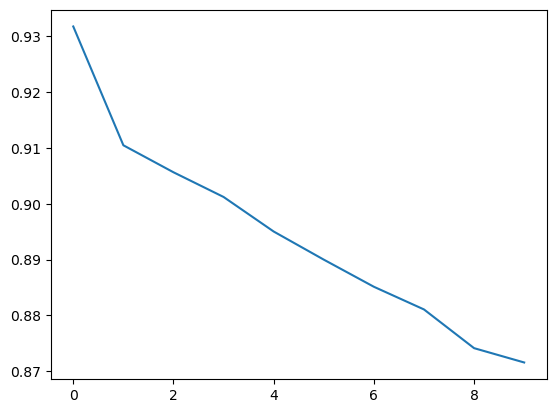

0:00:04.557168
epoch 10:, dice_loss=0.86450732, lr= 0.001
0:00:04.608957
epoch 11:, dice_loss=0.86033481, lr= 0.001
0:00:04.515559
epoch 12:, dice_loss=0.85474074, lr= 0.001
0:00:04.401543
epoch 13:, dice_loss=0.84635580, lr= 0.001
0:00:04.608665
epoch 14:, dice_loss=0.83380735, lr= 0.001
0:00:04.899417
epoch 15:, dice_loss=0.82358122, lr= 0.001
0:00:04.607799
epoch 16:, dice_loss=0.81798267, lr= 0.001
0:00:04.807651
epoch 17:, dice_loss=0.81097603, lr= 0.001
0:00:04.571541
epoch 18:, dice_loss=0.79716188, lr= 0.001
0:00:05.018398
epoch 19:, dice_loss=0.78952736, lr= 0.001


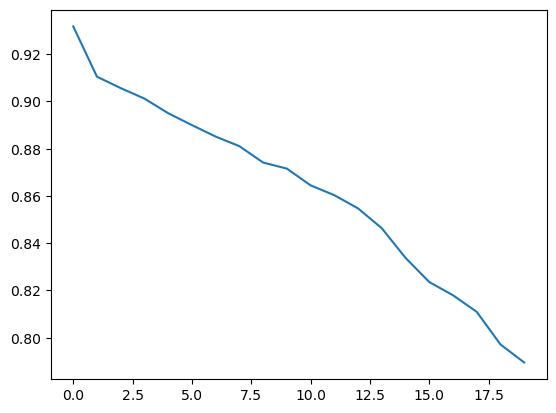

0:00:05.492718
epoch 20:, dice_loss=0.77391487, lr= 0.001
0:00:04.552370
epoch 21:, dice_loss=0.76068455, lr= 0.001
0:00:04.685979
epoch 22:, dice_loss=0.74780929, lr= 0.001
0:00:04.605386
epoch 23:, dice_loss=0.74171513, lr= 0.001
0:00:05.149244
epoch 24:, dice_loss=0.73189265, lr= 0.001
0:00:05.076293
epoch 25:, dice_loss=0.72412306, lr= 0.001
0:00:04.900473
epoch 26:, dice_loss=0.71083421, lr= 0.001
0:00:04.644424
epoch 27:, dice_loss=0.70364076, lr= 0.001
0:00:04.750209
epoch 28:, dice_loss=0.69846153, lr= 0.001
0:00:04.586405
epoch 29:, dice_loss=0.69648087, lr= 0.001


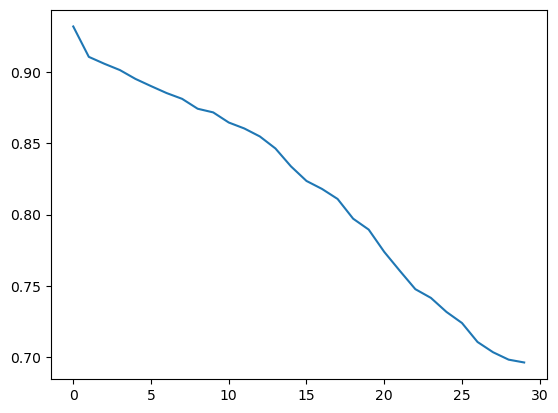

0:00:04.609359
epoch 30:, dice_loss=0.67994630, lr= 0.001
0:00:04.658874
epoch 31:, dice_loss=0.67704380, lr= 0.001
0:00:04.826241
epoch 32:, dice_loss=0.66880232, lr= 0.001
0:00:04.514096
epoch 33:, dice_loss=0.65591663, lr= 0.001
0:00:04.782469
epoch 34:, dice_loss=0.64423001, lr= 0.001
0:00:04.547944
epoch 35:, dice_loss=0.64247668, lr= 0.001
0:00:04.936617
epoch 36:, dice_loss=0.63232940, lr= 0.001
0:00:05.066877
epoch 37:, dice_loss=0.62824154, lr= 0.001
0:00:05.208360
epoch 38:, dice_loss=0.61581242, lr= 0.001
0:00:04.794516
epoch 39:, dice_loss=0.61351693, lr= 0.001


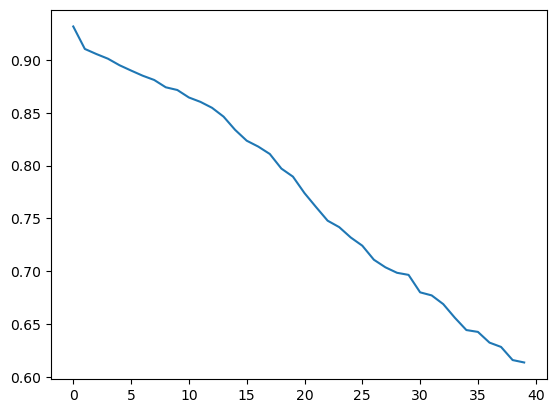

0:00:04.577798
epoch 40:, dice_loss=0.60880762, lr= 0.001
0:00:04.396065
epoch 41:, dice_loss=0.59838170, lr= 0.001
0:00:04.467906
epoch 42:, dice_loss=0.58744210, lr= 0.001
0:00:04.518988
epoch 43:, dice_loss=0.58021313, lr= 0.001
0:00:04.519211
epoch 44:, dice_loss=0.57527322, lr= 0.001
0:00:04.638772
epoch 45:, dice_loss=0.57673424, lr= 0.001
0:00:04.420787
epoch 46:, dice_loss=0.57724243, lr= 0.001
0:00:04.547804
epoch 47:, dice_loss=0.56715661, lr= 0.001
0:00:04.531596
epoch 48:, dice_loss=0.55774814, lr= 0.001
0:00:04.611252
epoch 49:, dice_loss=0.54864061, lr= 0.001


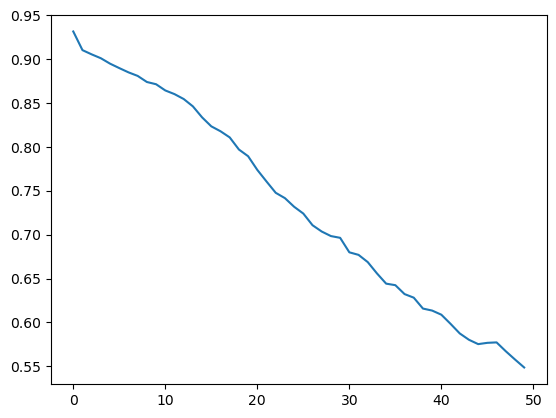

0:00:04.585151
epoch 50:, dice_loss=0.54445493, lr= 0.001
0:00:04.915182
epoch 51:, dice_loss=0.53446329, lr= 0.001
0:00:04.660450
epoch 52:, dice_loss=0.53460628, lr= 0.001
0:00:04.651912
epoch 53:, dice_loss=0.52844703, lr= 0.001
0:00:04.380766
epoch 54:, dice_loss=0.52018785, lr= 0.001
0:00:04.490393
epoch 55:, dice_loss=0.51499856, lr= 0.001
0:00:04.501318
epoch 56:, dice_loss=0.50754619, lr= 0.001
0:00:04.590865
epoch 57:, dice_loss=0.50077134, lr= 0.001
0:00:04.544655
epoch 58:, dice_loss=0.49462494, lr= 0.001
0:00:04.632229
epoch 59:, dice_loss=0.48922396, lr= 0.001


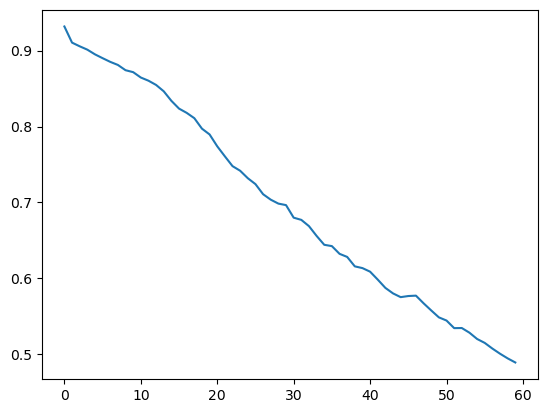

0:00:04.689293
epoch 60:, dice_loss=0.48627633, lr= 0.001
0:00:05.606679
epoch 61:, dice_loss=0.48655269, lr= 0.001
0:00:04.683591
epoch 62:, dice_loss=0.49487373, lr= 0.001
0:00:04.852452
epoch 63:, dice_loss=0.49336714, lr= 0.001
0:00:04.675247
epoch 64:, dice_loss=0.48366004, lr= 0.001
0:00:04.568386
epoch 65:, dice_loss=0.47983518, lr= 0.001
0:00:04.516836
epoch 66:, dice_loss=0.46729183, lr= 0.001
0:00:04.350031
epoch 67:, dice_loss=0.46180448, lr= 0.001
0:00:04.522289
epoch 68:, dice_loss=0.45747390, lr= 0.001
0:00:04.655141
epoch 69:, dice_loss=0.45110878, lr= 0.001


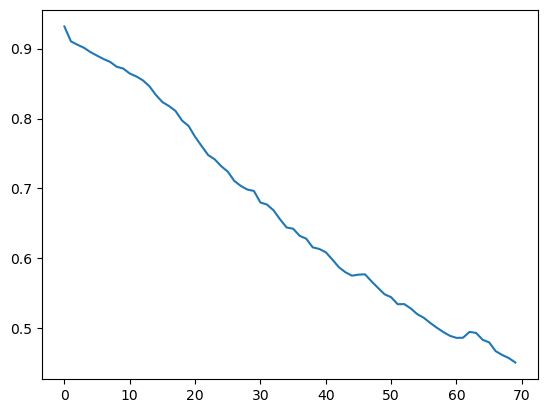

0:00:04.624218
epoch 70:, dice_loss=0.44548535, lr= 0.001
0:00:04.619673
epoch 71:, dice_loss=0.44426632, lr= 0.001
0:00:04.620062
epoch 72:, dice_loss=0.44499788, lr= 0.001
0:00:04.471200
epoch 73:, dice_loss=0.44395894, lr= 0.001
0:00:04.543139
epoch 74:, dice_loss=0.44284967, lr= 0.001
0:00:04.507773
epoch 75:, dice_loss=0.44106293, lr= 0.001
0:00:04.538100
epoch 76:, dice_loss=0.43881240, lr= 0.001
0:00:04.548305
epoch 77:, dice_loss=0.43424413, lr= 0.001
0:00:04.576857
epoch 78:, dice_loss=0.43642241, lr= 0.001
0:00:04.749881
epoch 79:, dice_loss=0.43252286, lr= 0.0005


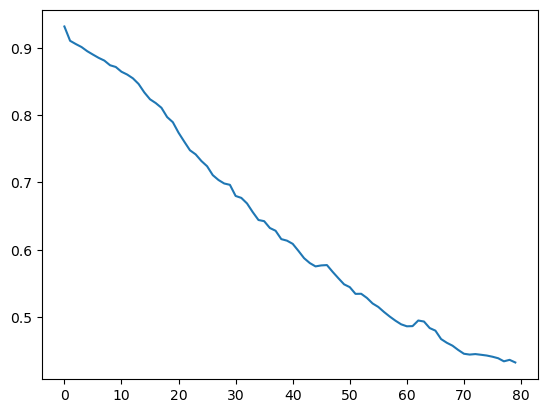

0:00:04.697475
epoch 80:, dice_loss=0.42913088, lr= 0.0005
0:00:04.591678
epoch 81:, dice_loss=0.42635044, lr= 0.0005
0:00:04.456427
epoch 82:, dice_loss=0.42438957, lr= 0.0005
0:00:04.684519
epoch 83:, dice_loss=0.42260519, lr= 0.0005
0:00:05.381339
epoch 84:, dice_loss=0.42111677, lr= 0.0005
0:00:04.698308
epoch 85:, dice_loss=0.42006654, lr= 0.0005
0:00:04.753967
epoch 86:, dice_loss=0.41908574, lr= 0.0005
0:00:04.791598
epoch 87:, dice_loss=0.41849571, lr= 0.0005
0:00:04.427348
epoch 88:, dice_loss=0.41774568, lr= 0.0005
0:00:04.396763
epoch 89:, dice_loss=0.41740188, lr= 0.0005


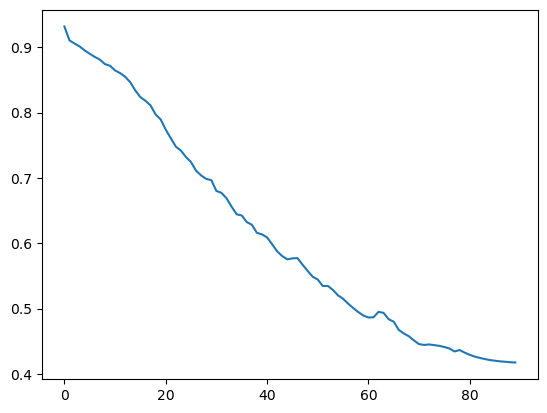

0:00:04.566436
epoch 90:, dice_loss=0.41708311, lr= 0.0005
0:00:04.513415
epoch 91:, dice_loss=0.41909447, lr= 0.0005
0:00:04.673185
epoch 92:, dice_loss=0.41718277, lr= 0.0005
0:00:04.745380
epoch 93:, dice_loss=0.41727808, lr= 0.0005
0:00:04.954449
epoch 94:, dice_loss=0.41676471, lr= 0.0005
0:00:04.516018
epoch 95:, dice_loss=0.41671965, lr= 0.0005
0:00:04.437199
epoch 96:, dice_loss=0.41516334, lr= 0.0005
0:00:04.638379
epoch 97:, dice_loss=0.41510454, lr= 0.0005
0:00:04.624254
epoch 98:, dice_loss=0.41434222, lr= 0.0005
0:00:04.490874
epoch 99:, dice_loss=0.41362885, lr= 0.0005


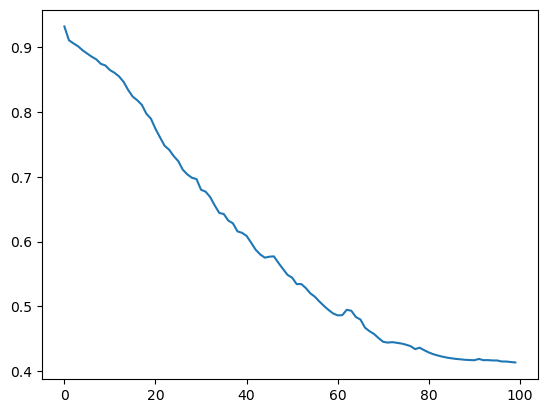

0:00:04.671874
epoch 100:, dice_loss=0.41403431, lr= 0.0005
0:00:04.540363
epoch 101:, dice_loss=0.41299319, lr= 0.0005
0:00:04.494820
epoch 102:, dice_loss=0.41157594, lr= 0.0005
0:00:05.012412
epoch 103:, dice_loss=0.41276672, lr= 0.0005
0:00:04.478284
epoch 104:, dice_loss=0.41137001, lr= 0.0005
0:00:04.462810
epoch 105:, dice_loss=0.41004062, lr= 0.0005
0:00:04.683270
epoch 106:, dice_loss=0.40929970, lr= 0.0005
0:00:05.001083
epoch 107:, dice_loss=0.40955308, lr= 0.0005
0:00:04.508355
epoch 108:, dice_loss=0.41148284, lr= 0.0005
0:00:04.613783
epoch 109:, dice_loss=0.41133830, lr= 0.0005


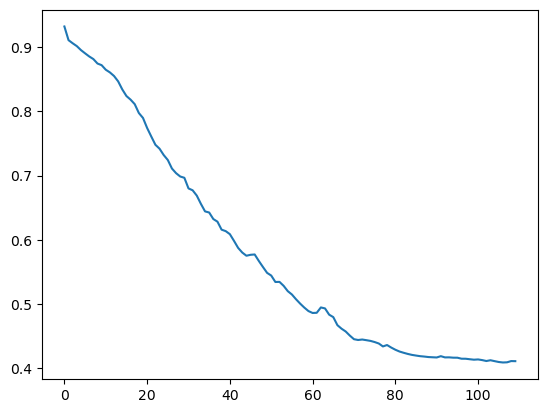

0:00:04.655682
epoch 110:, dice_loss=0.41467428, lr= 0.0005
0:00:04.644577
epoch 111:, dice_loss=0.41455597, lr= 0.0005
0:00:04.557894
epoch 112:, dice_loss=0.41037944, lr= 0.0005
0:00:04.509216
epoch 113:, dice_loss=0.41022962, lr= 0.0005
0:00:04.666550
epoch 114:, dice_loss=0.41083601, lr= 0.0005
0:00:04.535292
epoch 115:, dice_loss=0.40949890, lr= 0.0005
0:00:04.946246
epoch 116:, dice_loss=0.40935421, lr= 0.0005
0:00:04.456642
epoch 117:, dice_loss=0.40970299, lr= 0.0005
0:00:04.429638
epoch 118:, dice_loss=0.40887204, lr= 0.0005
0:00:04.407572
epoch 119:, dice_loss=0.40874198, lr= 0.0005


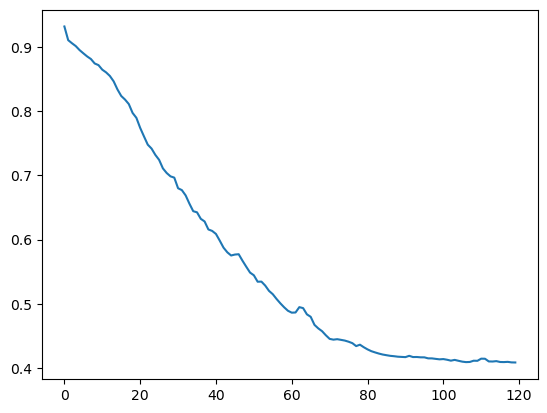

0:00:04.447942
epoch 120:, dice_loss=0.40799353, lr= 0.0005
0:00:04.394672
epoch 121:, dice_loss=0.40597099, lr= 0.0005
0:00:04.416008
epoch 122:, dice_loss=0.40555748, lr= 0.0005
0:00:05.044137
epoch 123:, dice_loss=0.40431494, lr= 0.0005
0:00:04.613552
epoch 124:, dice_loss=0.40565848, lr= 0.0005
0:00:04.782820
epoch 125:, dice_loss=0.40494105, lr= 0.0005
0:00:04.653517
epoch 126:, dice_loss=0.40763548, lr= 0.0005
0:00:04.867158
epoch 127:, dice_loss=0.40621004, lr= 0.0005
0:00:04.611422
epoch 128:, dice_loss=0.40609163, lr= 0.0005
0:00:04.522580
epoch 129:, dice_loss=0.40447685, lr= 0.0005


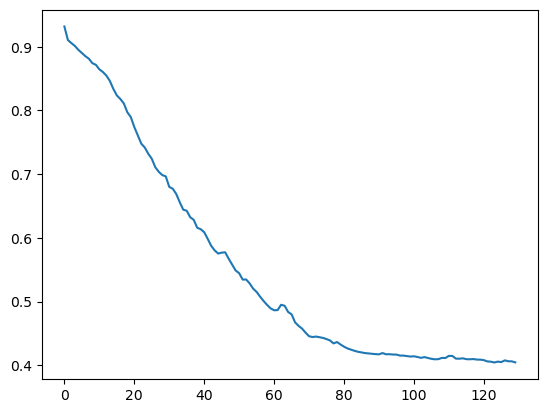

0:00:04.601053
epoch 130:, dice_loss=0.40434036, lr= 0.0005
0:00:04.538700
epoch 131:, dice_loss=0.40393689, lr= 0.0005
0:00:05.200685
epoch 132:, dice_loss=0.40447828, lr= 0.0005
0:00:04.745083
epoch 133:, dice_loss=0.40646249, lr= 0.0005
0:00:04.563407
epoch 134:, dice_loss=0.40748432, lr= 0.0005
0:00:04.574017
epoch 135:, dice_loss=0.41480261, lr= 0.0005
0:00:04.682820
epoch 136:, dice_loss=0.42186815, lr= 0.0005
0:00:04.478544
epoch 137:, dice_loss=0.42376500, lr= 0.0005
0:00:04.637247
epoch 138:, dice_loss=0.42054275, lr= 0.0005
0:00:04.699704
epoch 139:, dice_loss=0.44024208, lr= 0.0005


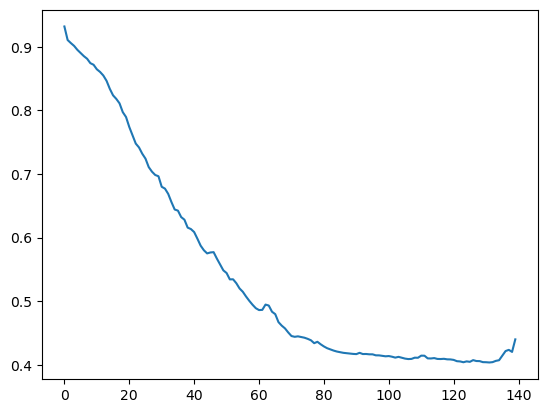

0:00:04.475477
epoch 140:, dice_loss=0.42294469, lr= 0.0005
0:00:04.639896
epoch 141:, dice_loss=0.41942284, lr= 0.0005
0:00:04.516121
epoch 142:, dice_loss=0.41409105, lr= 0.0005
0:00:04.676735
epoch 143:, dice_loss=0.41150656, lr= 0.0005
0:00:05.056404
epoch 144:, dice_loss=0.40851828, lr= 0.0005
0:00:04.542096
epoch 145:, dice_loss=0.40576023, lr= 0.0005
0:00:04.641868
epoch 146:, dice_loss=0.40458789, lr= 0.0005
0:00:04.603665
epoch 147:, dice_loss=0.40459949, lr= 0.0005
0:00:04.515989
epoch 148:, dice_loss=0.40330198, lr= 0.0005
0:00:04.677773
epoch 149:, dice_loss=0.40335461, lr= 0.0005


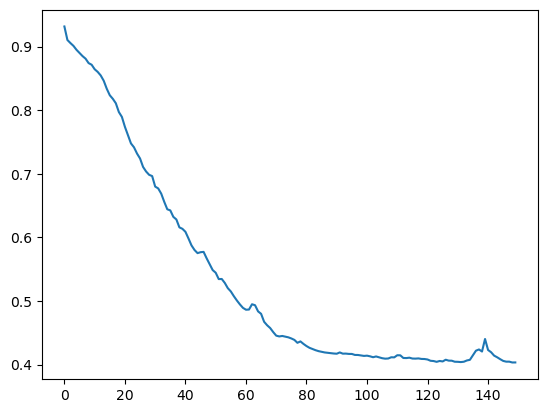

0:00:04.614062
epoch 150:, dice_loss=0.40339008, lr= 0.0005
0:00:04.630620
epoch 151:, dice_loss=0.40259767, lr= 0.0005
0:00:04.899315
epoch 152:, dice_loss=0.40223578, lr= 0.0005
0:00:04.611750
epoch 153:, dice_loss=0.40291151, lr= 0.0005
0:00:04.479446
epoch 154:, dice_loss=0.40300956, lr= 0.0005
0:00:04.560031
epoch 155:, dice_loss=0.40203708, lr= 0.0005
0:00:04.559263
epoch 156:, dice_loss=0.40360877, lr= 0.0005
0:00:04.556597
epoch 157:, dice_loss=0.40305886, lr= 0.0005
0:00:04.427686
epoch 158:, dice_loss=0.40026122, lr= 0.0005
0:00:04.620981
epoch 159:, dice_loss=0.40085897, lr= 0.00025


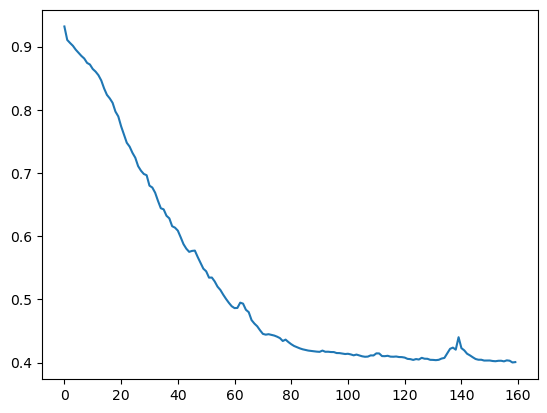

0:00:04.750697
epoch 160:, dice_loss=0.39983830, lr= 0.00025
0:00:04.525674
epoch 161:, dice_loss=0.39862266, lr= 0.00025
0:00:04.497636
epoch 162:, dice_loss=0.39819390, lr= 0.00025
0:00:04.480833
epoch 163:, dice_loss=0.39814001, lr= 0.00025
0:00:04.548007
epoch 164:, dice_loss=0.39797631, lr= 0.00025
0:00:04.491656
epoch 165:, dice_loss=0.39765105, lr= 0.00025
0:00:04.541628
epoch 166:, dice_loss=0.39745277, lr= 0.00025
0:00:04.572592
epoch 167:, dice_loss=0.39746383, lr= 0.00025
0:00:04.511999
epoch 168:, dice_loss=0.39733273, lr= 0.00025
0:00:05.170820
epoch 169:, dice_loss=0.39694610, lr= 0.00025


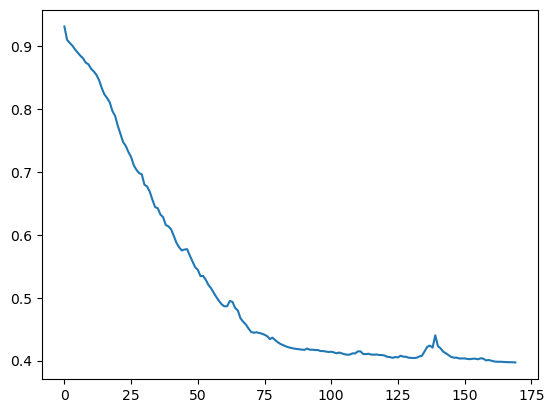

0:00:04.921107
epoch 170:, dice_loss=0.39668065, lr= 0.00025
0:00:04.723806
epoch 171:, dice_loss=0.39631119, lr= 0.00025
0:00:04.674921
epoch 172:, dice_loss=0.39629266, lr= 0.00025
0:00:04.516235
epoch 173:, dice_loss=0.39616051, lr= 0.00025
0:00:04.474576
epoch 174:, dice_loss=0.39608291, lr= 0.00025
0:00:04.547516
epoch 175:, dice_loss=0.39602044, lr= 0.00025
0:00:04.484678
epoch 176:, dice_loss=0.39582101, lr= 0.00025
0:00:04.613058
epoch 177:, dice_loss=0.39572302, lr= 0.00025
0:00:04.682072
epoch 178:, dice_loss=0.39587119, lr= 0.00025
0:00:04.625252
epoch 179:, dice_loss=0.39550352, lr= 0.00025


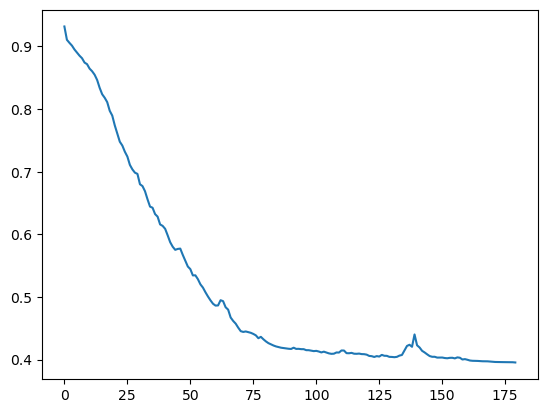

0:00:05.536296
epoch 180:, dice_loss=0.39566240, lr= 0.00025
0:00:04.889177
epoch 181:, dice_loss=0.39588165, lr= 0.00025
0:00:04.685964
epoch 182:, dice_loss=0.39519587, lr= 0.00025
0:00:04.700778
epoch 183:, dice_loss=0.39532062, lr= 0.00025
0:00:04.764943
epoch 184:, dice_loss=0.39542827, lr= 0.00025
0:00:04.718333
epoch 185:, dice_loss=0.39527535, lr= 0.00025
0:00:04.718609
epoch 186:, dice_loss=0.39603814, lr= 0.00025
0:00:04.716344
epoch 187:, dice_loss=0.39595446, lr= 0.00025
0:00:04.633575
epoch 188:, dice_loss=0.39595243, lr= 0.00025
0:00:04.575973
epoch 189:, dice_loss=0.39705756, lr= 0.00025


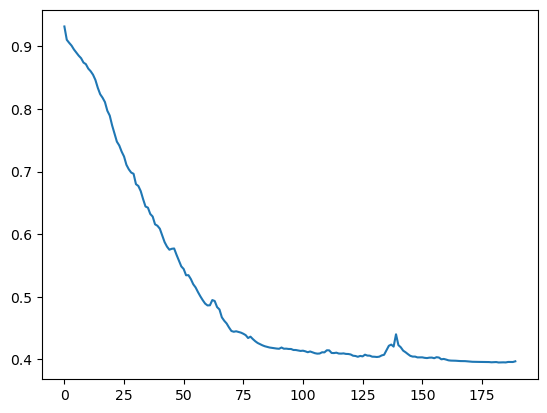

0:00:04.512308
epoch 190:, dice_loss=0.39669201, lr= 0.00025
0:00:04.814767
epoch 191:, dice_loss=0.39525968, lr= 0.00025
0:00:05.145187
epoch 192:, dice_loss=0.39488870, lr= 0.00025
0:00:04.986189
epoch 193:, dice_loss=0.39516425, lr= 0.00025
0:00:04.592014
epoch 194:, dice_loss=0.39474568, lr= 0.00025
0:00:04.574771
epoch 195:, dice_loss=0.39459261, lr= 0.00025
0:00:04.412535
epoch 196:, dice_loss=0.39544964, lr= 0.00025
0:00:04.675555
epoch 197:, dice_loss=0.39490542, lr= 0.00025
0:00:04.500725
epoch 198:, dice_loss=0.39476237, lr= 0.00025
0:00:04.551743
epoch 199:, dice_loss=0.39526024, lr= 0.00025


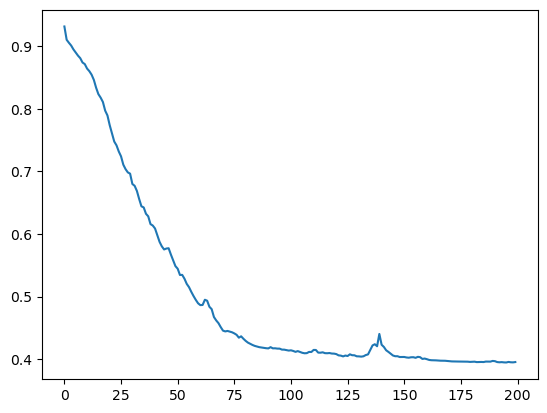

In [23]:
m.fit()

Validation

In [24]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
best_i = -1
best_dice = 0
for i in range(80,100):
    m.load_model(i)
    pred, masks = m.validate('val', 32)
    # pred = pred.astype(np.uint16)
    dice = 0
    t = 0
    for j  in range(len(pred)):
        if np.count_nonzero(masks[j]) != 0:
            dice += calculate_dice(masks[j], pred[j])
            t += 1
    dice /= t
    print('epoch = ', i,'dice = ', dice)
    if dice > best_dice:
        best_i = i
        best_dice = dice
print('best_i = ', best_i)

epoch =  80 dice =  0.491443424403665
epoch =  81 dice =  0.4790155043734476
epoch =  82 dice =  0.47908659472479254
epoch =  83 dice =  0.480833999537469
epoch =  84 dice =  0.4834055453500897
epoch =  85 dice =  0.4859265788434115
epoch =  86 dice =  0.48588960013532345
epoch =  87 dice =  0.48997624214059493
epoch =  88 dice =  0.48792346788237106
epoch =  89 dice =  0.4946359144399799
epoch =  90 dice =  0.47771344255931136
epoch =  91 dice =  0.4771438631550277
epoch =  92 dice =  0.4876248864601436
epoch =  93 dice =  0.49198126633420536
epoch =  94 dice =  0.4810332694680871
epoch =  95 dice =  0.46454863560154935
epoch =  96 dice =  0.4898408757245542
epoch =  97 dice =  0.48090084980921133
epoch =  98 dice =  0.48188677242301864
epoch =  99 dice =  0.4877511689966036
best_i =  89


epoch =  69 dice =  0.4946359144399799


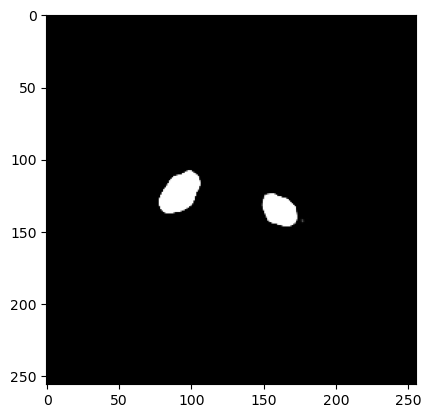

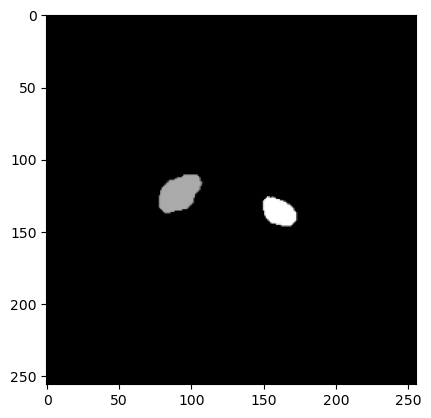

In [10]:
def calculate_dice(pred, mask):
    intersection = np.multiply(pred,mask)
    union  = np.sum(pred) + np.sum(mask)
    dice = (2 * np.sum(intersection))/union
    return dice
m.load_model(89)
pred, masks = m.validate('val', 32)
dice = 0
t = 0
for j  in range(len(pred)):
    if np.count_nonzero(masks[j]) != 0:
        dice += calculate_dice(masks[j], pred[j])
        t += 1
dice /= t
print('epoch = ', 69,'dice = ', dice)
plt.imshow(pred[25], cmap = 'gray')
plt.show()
plt.imshow(masks[25], cmap = 'gray')

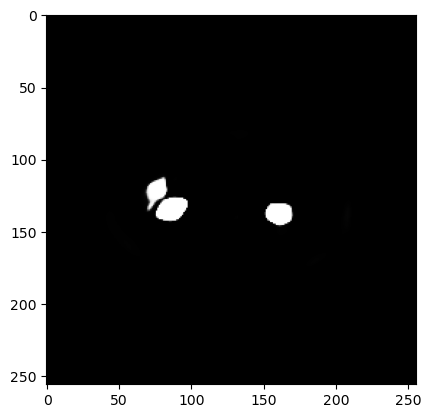

3.972782e-05 1.0 0.0 0.7411765
0.5750524108360067


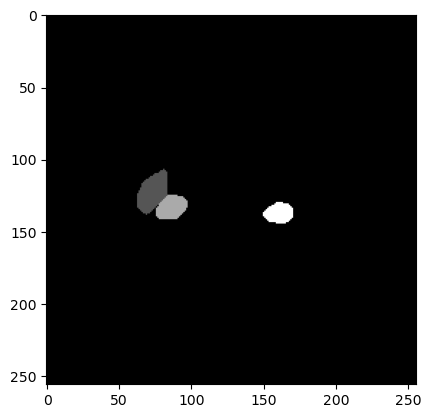

In [15]:
i = 50
plt.imshow(pred[i], cmap = 'gray')
plt.show()
plt.imshow(masks[i], cmap = 'gray')
print(np.min(pred[i]), np.max(pred[i]), np.min(masks[i]), np.max(masks[i]))
dice = calculate_dice(masks[i], pred[i])
print(dice)